# Multivariate Logistic Regression Demo

> ☝Before moving on with this demo you might want to take a look at:
> - 📗[Math behind the Logistic Regression](https://github.com/trekhleb/homemade-machine-learning/tree/master/homemade/logistic_regression)
> - ⚙️[Logistic Regression Source Code](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/logistic_regression/logistic_regression.py)

**Logistic regression** is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary). Like all regression analyses, the logistic regression is a predictive analysis. Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Logistic Regression is used when the dependent variable (target) is categorical.

For example:

- To predict whether an email is spam (`1`) or (`0`).
- Whether online transaction is fraudulent (`1`) or not (`0`).
- Whether the tumor is malignant (`1`) or not (`0`).

> **Demo Project:** In this example we will train handwritten digits (0-9) classifier.

In [1]:
# To make debugging of logistic_regression module easier we enable imported modules autoreloading feature.
# By doing this you may change the code of logistic_regression library and all these changes will be available here.
%load_ext autoreload
%autoreload 2

# Add project root folder to module loading paths.
import sys
sys.path.append('../..')

### Import Dependencies

- [pandas](https://pandas.pydata.org/) - library that we will use for loading and displaying the data in a table
- [numpy](http://www.numpy.org/) - library that we will use for linear algebra operations
- [matplotlib](https://matplotlib.org/) - library that we will use for plotting the data
- [math](https://docs.python.org/3/library/math.html) - math library that we will use to calculate sqaure roots etc.
- [logistic_regression](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/logistic_regression/logistic_regression.py) - custom implementation of logistic regression

In [2]:
# Import 3rd party dependencies.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Import custom linear regression implementation.
from homemade.logistic_regression import LogisticRegression

### Load the Data

In this demo we will be using a sample of [MNIST dataset in a CSV format](https://www.kaggle.com/oddrationale/mnist-in-csv/home). Instead of using full dataset with 60000 training examples we will use cut dataset of just 10000 examples that we will also split into training and testing sets.

Each row in the dataset consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values (28x28 pixels image) are the pixel values (a number from 0 to 255).

In [3]:
# Load the data.
data = pd.read_csv('../../data/mnist-demo.csv')

# Print the data table.
data.head(10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Plot the Data

Let's peek first 25 rows of the dataset and display them as an images to have an example of digits we will be working with.

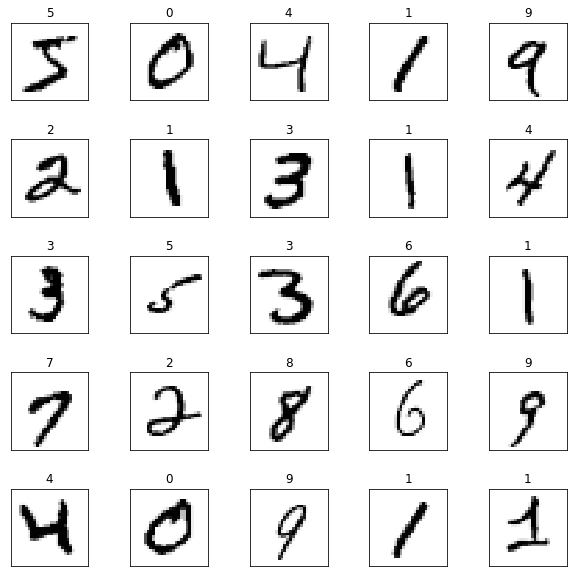

In [4]:
# How many numbers to display.
numbers_to_display = 25

# Calculate the number of cells that will hold all the numbers.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(10, 10))

# Go through the first numbers in a training set and plot them.
for plot_index in range(numbers_to_display):
    # Extrace digit data.
    digit = data[plot_index:plot_index + 1].values
    digit_label = digit[0][0]
    digit_pixels = digit[0][1:]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the number matrix.
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap='Greys')
    plt.title(digit_label)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Split the Data Into Training and Test Sets

In this step we will split our dataset into _training_ and _testing_ subsets (in proportion 70/30%).

Training data set will be used for training of our model. Testing dataset will be used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

In [5]:
# Split data set on training and test sets with proportions 70/30.
# Function sample() returns a random sample of items.
pd_train_data = data.sample(frac=0.7)
pd_test_data = data.drop(pd_train_data.index)

# Convert training and testing data from Pandas to NumPy format.
train_data = pd_train_data.values
test_data = pd_test_data.values

# Extract training/test labels and features.
num_training_examples = 5000
x_train = train_data[:num_training_examples, 1:]
y_train = train_data[:num_training_examples, [0]]

x_test = test_data[:, 1:]
y_test = test_data[:, [0]]

### Init and Train Logistic Regression Model

> ☝🏻This is the place where you might want to play with model configuration.

- `polynomial_degree` - this parameter will allow you to add additional polynomial features of certain degree. More features - more curved the line will be.
- `max_iterations` - this is the maximum number of iterations that gradient descent algorithm will use to find the minimum of a cost function. Low numbers may prevent gradient descent from reaching the minimum. High numbers will make the algorithm work longer without improving its accuracy.
- `regularization_param` - parameter that will fight overfitting. The higher the parameter, the simplier is the model will be.
- `polynomial_degree` - the degree of additional polynomial features (`x1^2 * x2, x1^2 * x2^2, ...`). This will allow you to curve the predictions.
- `sinusoid_degree` - the degree of sinusoid parameter multipliers of additional features (`sin(x), sin(2*x), ...`). This will allow you to curve the predictions by adding sinusoidal component to the prediction curve.
- `normalize_data` - boolean flag that indicates whether data normalization is needed or not.

In [6]:
# Set up linear regression parameters.
max_iterations = 10000  # Max number of gradient descent iterations.
regularization_param = 0  # Helps to fight model overfitting.
polynomial_degree = 0  # The degree of additional polynomial features.
sinusoid_degree = 0  # The degree of sinusoid parameter multipliers of additional features.
normalize_data = True  # Whether we need to normalize data to make it more unifrom or not. 

# Init logistic regression instance.
logistic_regression = LogisticRegression(x_train, y_train, polynomial_degree, sinusoid_degree, normalize_data)

# Train logistic regression.
(thetas, costs) = logistic_regression.train(regularization_param, max_iterations)

### Print Training Results

Let's see how model parameters (thetas) look like. For each digit class (from 0 to 9) we've just trained a set of 784 parameters (one theta for each image pixel). These parameters represents the importance of every pixel for specific digit recognition. 

In [7]:
# Print thetas table.
pd.DataFrame(thetas)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,-20.673233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.102771,0.074921,0.006305,-0.113603,0.0,0.0,0.0,0.0,0.0,0.0
1,-25.900273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.095026,0.059881,0.088396,0.115917,0.0,0.0,0.0,0.0,0.0,0.0
2,-31.540886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.615266,0.552717,0.354068,0.218729,0.0,0.0,0.0,0.0,0.0,0.0
3,-58.440852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.712773,1.149003,0.565164,0.272435,0.0,0.0,0.0,0.0,0.0,0.0
4,-32.618351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.444181,0.310963,0.069815,0.135156,0.0,0.0,0.0,0.0,0.0,0.0
5,-38.120808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.286158,0.187633,0.012823,-0.256106,0.0,0.0,0.0,0.0,0.0,0.0
6,-24.446586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.019648,0.001072,0.029114,0.216066,0.0,0.0,0.0,0.0,0.0,0.0
7,-28.167661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.182741,-0.112069,0.194151,0.447411,0.0,0.0,0.0,0.0,0.0,0.0
8,-82.117596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.378999,0.917658,-0.256050,-0.497725,0.0,0.0,0.0,0.0,0.0,0.0
9,-75.137929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.049056,0.786016,0.030567,-0.581839,0.0,0.0,0.0,0.0,0.0,0.0


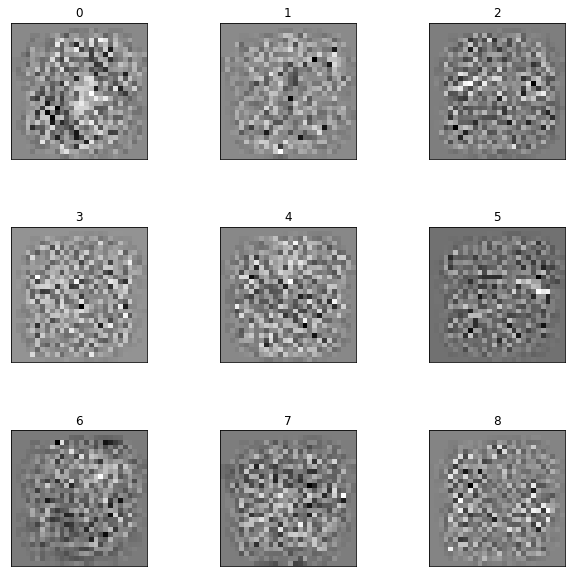

In [8]:
# How many numbers to display.
numbers_to_display = 9

# Calculate the number of cells that will hold all the numbers.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(10, 10))

# Go through the thetas and print them.
for plot_index in range(numbers_to_display):
    # Extrace digit data.
    digit_pixels = thetas[plot_index][1:]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the number matrix.
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap='Greys')
    plt.title(plot_index)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Analyze Gradient Descent Progress

The plot below illustrates how the cost function value changes over each iteration. You should see it decreasing. 

In case if cost function value increases it may mean that gradient descent missed the cost function minimum and with each step it goes further away from it.

From this plot you may also get an understanding of how many iterations you need to get an optimal value of the cost function.

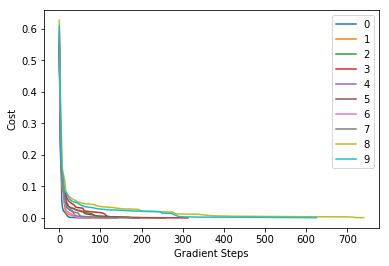

In [9]:
# Draw gradient descent progress for each label.
labels = logistic_regression.unique_labels
for index, label in enumerate(labels):
    plt.plot(range(len(costs[index])), costs[index], label=labels[index])

plt.xlabel('Gradient Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()

### Calculate Model Training Precision

Calculate how many of training and test examples have been classified correctly. Normally we need test precission to be as high as possible. In case if training precision is high and test precission is low it may mean that our model is overfitted (it works really well with the training data set but it is not good at classifying new unknown data from the test dataset). In this case you may want to play with `regularization_param` parameter to fighth the overfitting.

In [10]:
# Make training set predictions.
y_train_predictions = logistic_regression.predict(x_train)
y_test_predictions = logistic_regression.predict(x_test)

# Check what percentage of them are actually correct.
train_precision = np.sum(y_train_predictions == y_train) / y_train.shape[0] * 100
test_precision = np.sum(y_test_predictions == y_test) / y_test.shape[0] * 100

print('Training Precision: {:5.4f}%'.format(train_precision))
print('Test Precision: {:5.4f}%'.format(test_precision))

Training Precision: 100.0000%
Test Precision: 80.9000%


../../homemade/utils/hypothesis/sigmoid.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


### Plot Test Dataset Predictions

In order to illustrate how our model classifies unknown examples let's plot first 64 predictions for testing dataset. All green digits on the plot below have been recognized corrctly but all the red digits have not been recognized correctly by our classifier. On top of each digit image you may see the class (the number) that has been recognized on the image.

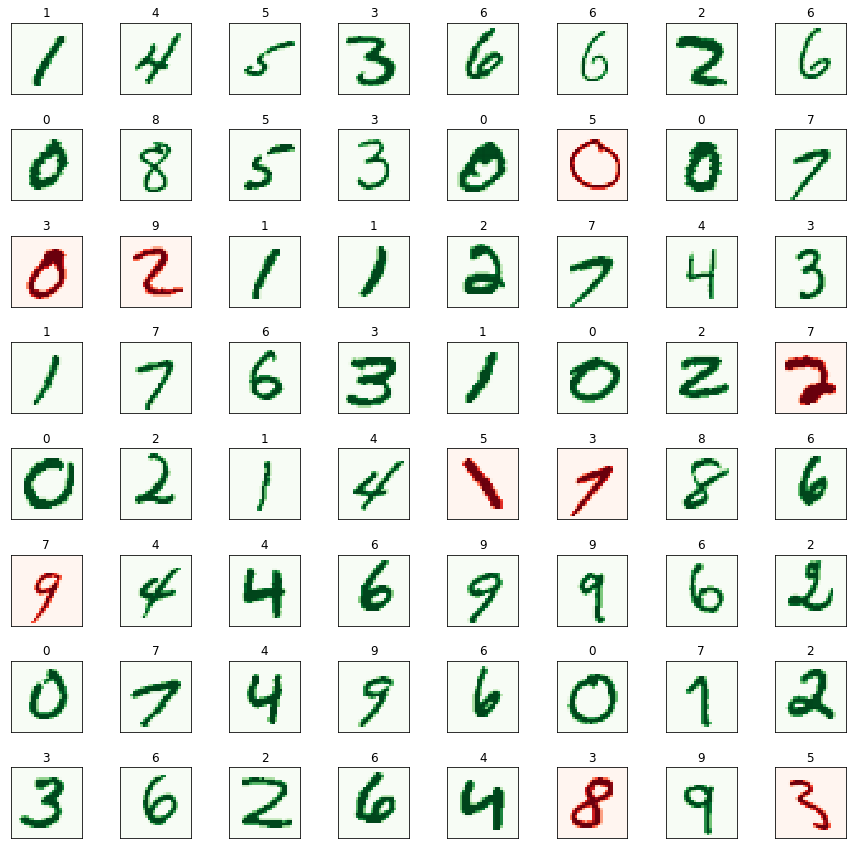

In [11]:
# How many numbers to display.
numbers_to_display = 64

# Calculate the number of cells that will hold all the numbers.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(15, 15))

# Go through the first numbers in a test set and plot them.
for plot_index in range(numbers_to_display):
    # Extrace digit data.
    digit_label = y_test[plot_index, 0]
    digit_pixels = x_test[plot_index, :]
    
    # Predicted label.
    predicted_label = y_test_predictions[plot_index][0]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the number matrix.
    color_map = 'Greens' if predicted_label == digit_label else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap=color_map)
    plt.title(predicted_label)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()